In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from z3 import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from PIL import Image

In [5]:
# Funções úteis
def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

def pintar_pixels(imagem, deleted_pixels):
    if not isinstance(imagem, np.ndarray):
        imagem = np.array(imagem)
        
    if imagem.ndim == 2:
        imagem = imagem.flatten()
        
    imagem = imagem.astype(np.uint8)
    
    imagem = imagem.reshape(28, 28)
    
    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()

    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28 
        pixels[x, y] = vermelho

    return imagem_rgb

def minimalExplanation(I, D, P):
    E = [x == u for x, u in zip(real_vars, I)]
    solver = Solver()
    red_pixels = []
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            red_pixels.append(i)


    return E, red_pixels


def minimalExplanationWithReturnInput(I, D, P):
    E = [x == u for x, u in zip(real_vars_iris, I)]
    print("Entrada original:", E)
    solver = Solver()
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            
    return E

Mnist accuracy: 0.9692089057318807


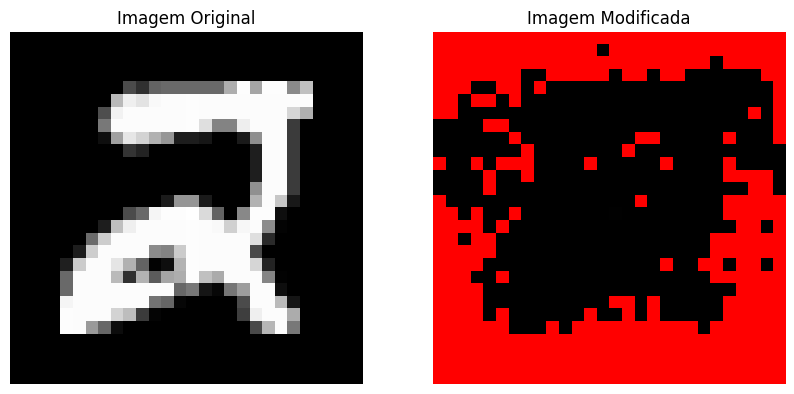

KeyboardInterrupt: 

In [7]:
# ------------------------------- MNIST -------------------------------

# Carregar e pré-processar os dados do MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Mudar as classes para 2, 4 e 7
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

scaler = MinMaxScaler()
scaler.fit(X_filtered)
scaler.set_output(transform='pandas')
X_filtered = scaler.transform(X_filtered)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

# Treinar o modelo de Regressão Logística
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
logistic_regression_classifier.fit(X_train, y_train)

# Fazer previsões e calcular a precisão
predictions = logistic_regression_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Mnist accuracy:", accuracy)

# Criar variáveis reais para Z3
real_vars = [Real('x_' + feature_name) for feature_name in X_filtered.columns]
domain_constraints_upper_bound = [x <= u for (x, u) in zip(real_vars, X_filtered.max())]
domain_constraints_lower_bound = [x >= l for (l, x) in zip(X_filtered.min(), real_vars)]
domain_constraints = domain_constraints_upper_bound + domain_constraints_lower_bound

# Definir os termos da regressão logística
logistic_reg1_term = logistic_regression_classifier.coef_[0] @ real_vars + logistic_regression_classifier.intercept_[0]
logistic_reg2_term = logistic_regression_classifier.coef_[1] @ real_vars + logistic_regression_classifier.intercept_[1]
logistic_reg3_term = logistic_regression_classifier.coef_[2] @ real_vars + logistic_regression_classifier.intercept_[2]

# Encontrar explicações minimais para as previsões do MNIST
for i in range(4):
    if(predictions[i] == 2):
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif(predictions[i] == 4):
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    img, red_pixel = minimalExplanation(X_test.iloc[i], domain_constraints, formula)
    
    img_rgb = pintar_pixels(X_test.iloc[i], red_pixel)
    # plot_mnist_image(np.array(X_test.iloc[i]))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.array(X_test.iloc[i]).reshape(28, 28), cmap='gray')
    axs[0].set_title('Imagem Original')
    axs[0].axis('off')


    axs[1].imshow(img_rgb)
    axs[1].set_title('Imagem Modificada')
    axs[1].axis('off')

    plt.show()

In [ ]:
# ------------------------------- IRIS -------------------------------

# Carregar e pré-processar os dados do Iris
X_iris, y_iris = load_iris(return_X_y=True, as_frame=True)

scaler = MinMaxScaler()
scaler.fit(X_iris)
scaler.set_output(transform='pandas')
X_iris = scaler.transform(X_iris)

# Dividir os dados em conjuntos de treino e teste
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.3, stratify=y_iris)

# Treinar o modelo de Regressão Logística para o Iris
iris_class = LogisticRegression(multi_class='multinomial', max_iter=200)
iris_class.fit(X_train_iris, y_train_iris)

# Fazer previsões e calcular a precisão
predictions_iris = iris_class.predict(X_test_iris)
accuracy_iris = accuracy_score(y_test_iris, predictions_iris)
print("Iris accuracy:", accuracy_iris)

# Criar variáveis reais para Z3
real_vars_iris = [Real('x_' + feature_name) for feature_name in X_iris.columns]
domain_constraints_upper_bound_iris = [x <= u for (x, u) in zip(real_vars_iris, X_iris.max())]
domain_constraints_lower_bound_iris = [x >= l for (l, x) in zip(X_iris.min(), real_vars_iris)]
domain_constraints_iris = domain_constraints_upper_bound_iris + domain_constraints_lower_bound_iris

# Definir os termos da regressão logística para o Iris
logistic_reg1_term_iris = iris_class.coef_[0] @ real_vars_iris + iris_class.intercept_[0]
logistic_reg2_term_iris = iris_class.coef_[1] @ real_vars_iris + iris_class.intercept_[1]
logistic_reg3_term_iris = iris_class.coef_[2] @ real_vars_iris + iris_class.intercept_[2]

# Encontrar explicações minimais para as previsões do Iris
for i in range(10):
    if(predictions_iris[i] == 0):
        formula = And(logistic_reg1_term_iris > logistic_reg2_term_iris, logistic_reg1_term_iris > logistic_reg3_term_iris)

    elif(predictions_iris[i] == 1):
        formula = And(logistic_reg2_term_iris > logistic_reg1_term_iris, logistic_reg2_term_iris > logistic_reg3_term_iris)

    else:
        formula = And(logistic_reg3_term_iris > logistic_reg1_term_iris, logistic_reg3_term_iris > logistic_reg2_term_iris)

    minexp = minimalExplanationWithReturnInput(X_test_iris.iloc[i], domain_constraints_iris, formula)
    print("Explicação minimal para a entrada {}:".format(i), minexp)

# ------------------------------- Fim -------------------------------

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from z3 import *
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Carregar o dataset MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Filtrar as classes 2, 4 e 7
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

# Pré-processamento dos dados
scaler = MinMaxScaler()
scaler.fit(X_filtered)
X_filtered = scaler.transform(X_filtered)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

# Treinar o modelo de Regressão Logística
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
logistic_regression_classifier.fit(X_train, y_train)

# Fazer previsões e calcular a precisão
predictions = logistic_regression_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Mnist accuracy:", accuracy)

# Criar variáveis reais para Z3
real_vars = [Real('x_' + str(i)) for i in range(X_filtered.shape[1])] 
domain_constraints = [And(x >= 0, x <= 1) for x in real_vars]

# Definir os termos da regressão logística para cada classe
logistic_reg_terms = [
    logistic_regression_classifier.coef_[i] @ real_vars + logistic_regression_classifier.intercept_[i]
    for i in range(len(classes_to_keep))
]

def minimalExplanation(I, formula):
    """
    Encontrar a explicação minimal para uma imagem.
    
    Args:
        I: Imagem de entrada como uma lista de valores.
        formula: Fórmula Z3 representando a predição correta.
    
    Returns:
        Uma lista de índices de pixels irrelevantes.
    """
    solver = Solver()
    solver.add(formula)
    solver.add(domain_constraints)
    solver.add([real_vars[i] == I[i] for i in range(len(I))])
    
    red_pixels = []
    for i in range(len(I) - 1, -1, -1):
        solver.reset()
        solver.add(formula)
        solver.add(domain_constraints)
        solver.add([real_vars[j] == I[j] for j in range(len(I)) if j != i])
        
        if solver.check() != sat:
            red_pixels.append(i)
    
    return red_pixels

# Encontrar e plotar uma amostra de cada classe com a explicação minimal
for target_class in classes_to_keep:
    # Encontrar uma imagem da classe alvo
    idx = np.where(y_test == target_class)[0][0]
    image = X_test[idx].reshape(28, 28)
    
    # Substituir os valores da imagem nas expressões simbólicas
    term_values = [
        float(simplify(t.subs([(real_vars[i], RealVal(X_test[idx][i])) for i in range(len(X_test[idx]))])).as_decimal())
        if simplify(t.subs([(real_vars[i], RealVal(X_test[idx][i])) for i in range(len(X_test[idx]))])).is_numeral()
        else 0.0  # Retorna 0.0 se a expressão não for um numeral
        for t in logistic_reg_terms
    ]

    # Criar a fórmula Z3 para a classe alvo
    formula = term_values[target_class] > max(
        [term_values[j] for j in range(len(classes_to_keep)) if j != target_class]
    )
    
    # Encontrar a explicação minimal
    red_pixels = minimalExplanation(X_test[idx], formula)

    # Pintar os pixels irrelevantes de vermelho
    img_rgb = Image.fromarray(image).convert("RGB")
    pixels = img_rgb.load()
    vermelho = (255, 0, 0)
    for index in red_pixels:
        x = index % 28
        y = index // 28
        pixels[x, y] = vermelho

    # Plotar a imagem modificada
    plt.imshow(img_rgb)
    plt.title(f"Classe {target_class} - Explicação Minimal")
    plt.axis('off')
    plt.show()

Mnist accuracy: 0.97063003315964


AttributeError: 'ArithRef' object has no attribute 'subs'